<a href="https://colab.research.google.com/github/PabloCGarcia/deepLearning/blob/main/Clase04_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
import tarfile
my_tar = tarfile.open('lfw.tgz')
my_tar.extractall('./lfw') # specify which folder to extract to
my_tar.close()

--2022-09-13 23:19:56--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  30.8MB/s    in 6.2s    

2022-09-13 23:20:02 (27.7 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
import os
%matplotlib inline

In [ ]:
images = []
for i in os.scandir('lfw/lfw'):
  for j in os.scandir(i.path):
    images.append(j.path)
images = tf.data.Dataset.from_tensor_slices(images)

In [ ]:
def get_ds(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  img = tf.divide(tf.subtract(tf.multiply(img,255),127.5),127.5)
  return tf.image.resize(img,(64,64))

In [ ]:
BATCH_SIZE = 64
train_images = images.map(get_ds,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).shuffle(60000)

In [ ]:
def make_generator_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(8*8*128,input_shape=(100,),use_bias=False))   
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8,8,128)))
    #assert model.output_shape == (None, 8, 8, 128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(1,1),padding='same',use_bias=False))    # stride (1,1) keeps the same shape as that of input
    #assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))     # stride (2,2) doubles the size of the input 
    #assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))     # stride (2,2) doubles the size of the input 
    #assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh',use_bias=False))
    #assert model.output_shape == (None, 64, 64, 3)
    ## output shape (28,28,1) the required shape
    
    return model

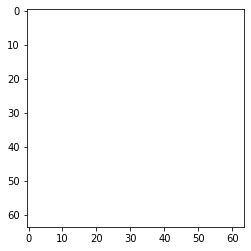

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0]*127.5+127.5)

In [ ]:
def make_discriminator_model():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00082034]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 200
noise_dims = 100
num_egs_to_generate = 16
seed = tf.random.normal([num_egs_to_generate,noise_dims])
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dims])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = generator(noise,training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradients = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))

In [ ]:
def generate_and_save_output(model,epoch,test_input):

  predictions = model(test_input,training=False)
  # predictions = predictions.numpy().reshape(16,64,64,1)
  fig = plt.figure(figsize=(4,4))
  # print(predictions)
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow((predictions[i]*127.5+127.5).numpy().astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig(f'image_at_epoch_{epoch}.png')
  plt.show()

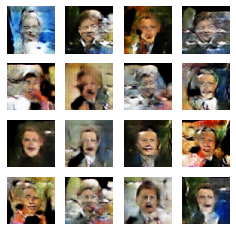

In [ ]:
from IPython import display
import time
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()
    for batch in dataset:
      train_step(batch)
    display.clear_output(wait=True)
    generate_and_save_output(generator,epoch+1,seed)

    #if (epoch+1)%15 == 0:
    #  checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start}')
  
  display.clear_output(wait=True)
  generate_and_save_output(generator,epochs,seed)
train(train_images,EPOCHS)

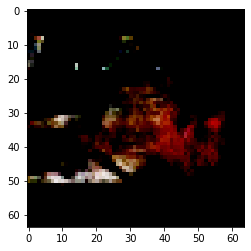

In [ ]:
new_image = generator(tf.random.normal([1,100]),training=False)
plt.imshow(new_image[0,:,:,:])